In [2]:
%run common.ipynb

Tensorflow version: 1.14.0
Keras version: 2.2.4
Numpy version: 1.16.5


## change method/model name to explore other model

In [4]:
m2, m1 = IRF_known1, GATA_disc1
method = check(m1)
keras_model_weights = '../model/model_single_' + m1 + '.h5'
keras_model_json = '../model/model_single_' + m1 + '.json'
keras_model = load_trained_model(keras_model_weights, keras_model_json)
testing_data = load_data(method, '../data/testing_' + m1 + '.npy')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [5]:
tr = testing_data.labels
pr = keras_model.predict(testing_data.onehot)
import sklearn
from sklearn import metrics
sklearn.metrics.roc_auc_score(tr, pr)
# print(tr.mean())

0.9951916666666668

In [6]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcance on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault


/home/wenboc/anaconda3/envs/deeplift/lib/python3.7/site-packages/deeplift/conversion/kerasapi_conversion.py:366: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  model_weights = h5py.File(h5_file)


For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 7 the preceding linear layer is 6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 10 the preceding linear layer is 9 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
nonlinear_mxts_mode is set to: Rescale
nonlinear_mxts_mode is set to: RevealCancel
nonlinear_mxts_mode is set to: Gradient
nonlinear_mxts_mode is set to: GuidedBackprop


In [7]:
#make sure predictions are the same as the original model
import deeplift
from deeplift.util import compile_func
model_to_test = method_to_model['rescale_conv_revealcancel_fc']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(testing_data.onehot, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[testing_data.onehot],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

maximum difference in predictions: 0.0


In [8]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
print("Compiling integrated gradients scoring functions")
integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
    gradient_computation_function = gradient_func,
    num_intervals=10)
method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_conv_revealcancel_fc
Compiling scoring function for: rescale_all_layers
Compiling scoring function for: revealcancel_all_layers
Compiling scoring function for: grad_times_inp
Compiling scoring function for: guided_backprop
Compiling integrated gradients scoring functions


In [9]:
background = OrderedDict([('A', 0.3), ('C', 0.2), ('G', 0.2), ('T', 0.3)])

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    method_to_task_to_scores[method_name] = OrderedDict()
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[testing_data.onehot],
                    input_references_list=[
                     np.array([background['A'],
                               background['C'],
                               background['G'],
                               background['T']])[None,None,:]],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
        # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
        # every position and you won't know which base is the one that is actually present in the sequence!
        scores = np.sum(scores, axis=2)
        method_to_task_to_scores[method_name][task_idx] = scores

on method rescale_conv_revealcancel_fc
on method rescale_all_layers
on method revealcancel_all_layers
on method grad_times_inp
on method guided_backprop
on method integrated_gradients10


In [10]:
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_conv_revealcancel_fc_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['rescale_conv_revealcancel_fc'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=20 #number of references to generate per sequence
method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)] = OrderedDict()
scores_without_sum_applied = rescale_conv_revealcancel_fc_many_refs_func(
            task_idx=[0,1,2], #can provide a list of tasks; references will be reused for each
            #Providing a single integeter for task_idx works too and would return a numpy array rather
            # than a list of numpy arrays
            input_data_sequences=testing_data.sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000)
for task_idx, scores in enumerate(scores_without_sum_applied):
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(scores,axis=2)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000


## Change idx to see explanation for other sample

Scores for task 0 for example 300


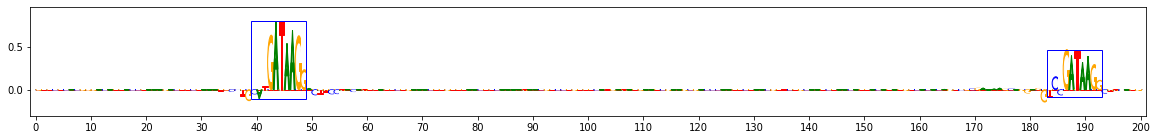

Scores for task 0 for example 301


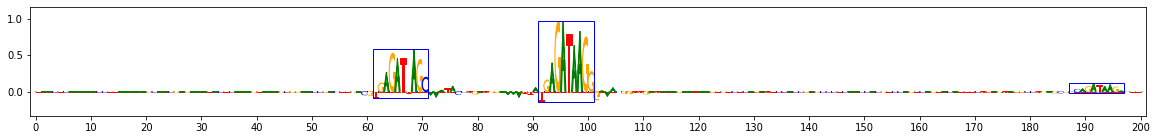

Scores for task 0 for example 302


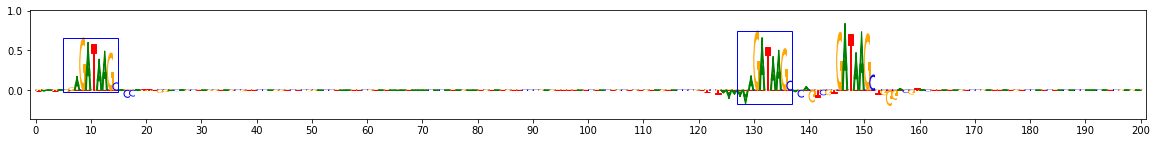

In [15]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

for task, idx in [(0,300 ), (0, 301), (0, 302)]:
    print("Scores for task",task,"for example",idx)
    for method_name in [
                        'rescale_conv_revealcancel_fc',
                        ]:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        original_onehot = testing_data.onehot[idx]
        scores_for_idx = original_onehot*scores_for_idx[:,None]
        # 750 GATA IRF
#         scores_for_idx[96:109] = -scores_for_idx[96:109]
        highlight = {'blue':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in testing_data.embeddings[idx] if 'GATA_disc1' in embedding.what.getDescription()],
                'green':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in testing_data.embeddings[idx] if 'TAL1_known1' in embedding.what.getDescription()],
                'red':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in testing_data.embeddings[idx] if 'IRF_known1' in embedding.what.getDescription()]
                }
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)